In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing, model_selection

In [2]:
df = pd.read_csv("Training Data.csv")

In [3]:
df.isnull().sum()

Unnamed: 0     0
id             0
keyword       61
text           1
target         0
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
df.head()

,Unnamed: 0,id,keyword,text,target
31,31,48,ablaze,bbcmtd wholesale markets ablaze,1
32,32,49,ablaze,we always try to bring the heavy metal rt,0
33,33,50,ablaze,africanbaze breaking newsnigeria flag set abla...,1
34,34,52,ablaze,crying out for more set me ablaze,0
35,35,53,ablaze,on plus side look at the sky last night it was...,0


In [6]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])

In [7]:
y = df['target']

In [8]:
df['target'].value_counts(normalize=True)

0    0.572375
1    0.427625
Name: target, dtype: float64

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [10]:
X_train.shape, X_test.shape

((5285, 16238), (2266, 16238))

In [11]:
y_train.shape, y_test.shape

((5285,), (2266,))

In [12]:
X_train

<5285x16238 sparse matrix of type '<class 'numpy.int64'>'
	with 42773 stored elements in Compressed Sparse Row format>

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train)
X_train_tf = tf_transformer.transform(X_train)
X_train_tf.shape

(5285, 16238)

In [14]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_test)
X_test_tf = tf_transformer.transform(X_test)
X_test_tf.shape

(2266, 16238)

# Naive Bayes Model

In [15]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [16]:
pred = clf.predict(X_test)

In [17]:
np.mean(pred == y_test)

0.796557811120918

The Naive Bayes Model achieves 80.41% accuracy.

In [18]:
scores = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring="f1")
scores

array([0.74857793, 0.73236282, 0.75398633, 0.74772727, 0.73565804])

In [19]:
clf_NB_TFIDF = MultinomialNB()
clf_NB_TFIDF.fit(X_train_tf, y_train)

MultinomialNB()

In [20]:
pred_tf = clf_NB_TFIDF.predict(X_test_tf)

In [21]:
np.mean(pred_tf == y_test)

0.7974404236540159

In [22]:
scores = model_selection.cross_val_score(clf_NB_TFIDF, X_train_tf, y_train, cv=5, scoring="f1")
scores

array([0.72979798, 0.70920245, 0.7225    , 0.73218673, 0.73284314])

In [23]:
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
print(metrics.classification_report(y_test, pred_tf))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1302
           1       0.84      0.65      0.73       964

    accuracy                           0.80      2266
   macro avg       0.81      0.78      0.78      2266
weighted avg       0.80      0.80      0.79      2266



In [24]:
metrics.confusion_matrix(y_test, pred_tf)

array([[1183,  119],
       [ 340,  624]], dtype=int64)

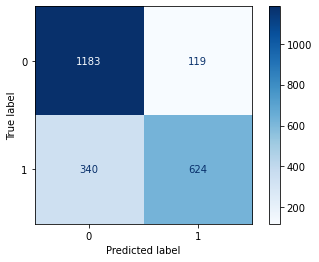

In [25]:
plot_confusion_matrix(clf_NB_TFIDF, X_test_tf, y_test, cmap='Blues')

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
clf.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [28]:
params = {'alpha':(0.5, 1, 1.5, 1.6, 1.7, 1.8, 1.9, 2)}

In [29]:
cv_clf = GridSearchCV(clf, param_grid = params, cv=5, n_jobs=-1, scoring = balanced_accuracy_score)

In [30]:
cv_clf.fit(X_train_tf, y_train)

C:\Users\malak\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': (0.5, 1, 1.5, 1.6, 1.7, 1.8, 1.9, 2)},
             scoring=<function balanced_accuracy_score at 0x0000029597D4B4C0>)

In [31]:
cv_clf.best_params_

{'alpha': 0.5}

In [32]:
clf_best = MultinomialNB(alpha = 0.5)
clf_best.fit(X_train_tf, y_train)
clf_best.predict(X_test_tf)

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [94]:
print("train accuracy:", clf_best.score(X_train_tf, y_train), "\n", "test accuracy:", clf_best.score(X_test_tf, y_test))

train accuracy: 0.9093661305581835 
 test accuracy: 0.8022947925860547


# Feature Importance

In [96]:
neg_class_prob_sorted = clf_best.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = clf_best.feature_log_prob_[1, :].argsort()[::-1]

print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:20]))
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:20]))

['im' 'just' 'like' 'amp' 'new' 'dont' 'body' 'love' 'people' 'got'
 'video' 'emergency' 'know' 'youtube' 'world' 'time' 'want' 'let' 'think'
 'day']
['news' 'california' 'people' 'disaster' 'suicide' 'fires' 'like' 'killed'
 'amp' 'storm' 'crash' 'police' 'buildings' 'wildfire' 'just' 'train'
 'emergency' 'families' 'accident' 'nuclear']


# SVM Model

In [36]:
from sklearn.linear_model import SGDClassifier
clfs = SGDClassifier(class_weight='balanced')

clfs.fit(X_train,y_train)
predicted = clfs.predict(X_test)
np.mean(predicted == y_test)

0.7621359223300971

In [37]:
scores = model_selection.cross_val_score(clfs, X_train, y_train, cv=5, scoring='f1')
scores

array([0.71034483, 0.69700333, 0.70215176, 0.71783296, 0.70428894])

In [38]:
clfs_tf = clfs.fit(X_train_tf, y_train)
predicted_tf = clfs_tf.predict(X_test_tf)
np.mean(predicted_tf == y_test)

0.7855251544571933

In [39]:
scores = model_selection.cross_val_score(clfs_tf, X_train_tf, y_train, cv=5, scoring='f1')
scores

array([0.74226804, 0.71524664, 0.72997712, 0.73957159, 0.73159683])

In [40]:
print(metrics.classification_report(y_test, predicted_tf))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1302
           1       0.77      0.71      0.74       964

    accuracy                           0.79      2266
   macro avg       0.78      0.78      0.78      2266
weighted avg       0.78      0.79      0.78      2266



In [41]:
metrics.confusion_matrix(y_test, predicted_tf)

array([[1093,  209],
       [ 277,  687]], dtype=int64)

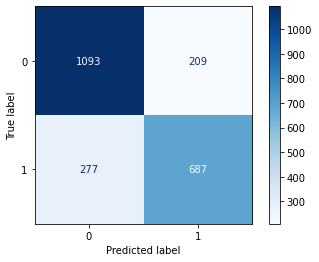

In [42]:
plot_confusion_matrix(clfs_tf, X_test_tf, y_test, cmap='Blues')

In [43]:
clfs.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': 'balanced',
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [44]:
params_clfs = {'alpha' :(0.001, 0.0001)}

In [45]:
cv_clfs = GridSearchCV(clfs_tf, param_grid = params_clfs, cv=5, n_jobs=-1)

In [46]:
cv_clfs.fit(X_train_tf, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(class_weight='balanced'), n_jobs=-1,
             param_grid={'alpha': (0.001, 0.0001)})

In [47]:
cv_clfs.best_params_

{'alpha': 0.001}

In [48]:
clfs_best = SGDClassifier(alpha = 0.0001)
clfs_best.fit(X_train_tf, y_train)
predtf_best = clfs_best.predict(X_test_tf)

In [49]:
print("train accuracy:", clfs_best.score(X_train_tf, y_train), "\n", "test accuracy:", clfs_best.score(X_test_tf, y_test))

train accuracy: 0.9509933774834437 
 test accuracy: 0.7925860547219771


# Logistic Regression Model

In [53]:
from sklearn.linear_model import LogisticRegression

In [54]:
clf_lr = LogisticRegression()

In [55]:
scores = model_selection.cross_val_score(clf_lr, X_train, y_train, cv=5, scoring='f1')
scores

array([0.74424242, 0.71752086, 0.73568819, 0.75358852, 0.73634204])

In [56]:
clf_lr.fit(X_train, y_train)

LogisticRegression()

In [57]:
y_pr = clf_lr.predict(X_test)

In [58]:
np.mean(y_test == y_pr)

0.793909973521624

In [59]:
clf_lr_tfidf = LogisticRegression()
scores = model_selection.cross_val_score(clf_lr_tfidf, X_train_tf, y_train, cv=5, scoring='f1')
scores

array([0.73232323, 0.69035533, 0.72151899, 0.73350254, 0.7079646 ])

In [60]:
clf_lr_tfidf.fit(X_train_tf, y_train)

LogisticRegression()

In [61]:
y_pr_tf = clf_lr_tfidf.predict(X_test_tf)

In [62]:
print(metrics.classification_report(y_test, y_pr_tf))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1302
           1       0.85      0.64      0.73       964

    accuracy                           0.80      2266
   macro avg       0.81      0.78      0.78      2266
weighted avg       0.81      0.80      0.79      2266



In [63]:
metrics.confusion_matrix(y_test, y_pr_tf)

array([[1195,  107],
       [ 351,  613]], dtype=int64)

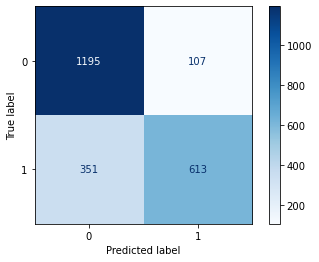

In [64]:
plot_confusion_matrix(clf_lr_tfidf, X_test_tf, y_test, cmap='Blues')

In [65]:
clf_lr_tfidf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [66]:
params_lr = {'C': (0.5, 1.0, 1.5, 2.0)}

In [67]:
clf_lr_cv = GridSearchCV(clf_lr, param_grid = params_lr, cv=5, scoring=balanced_accuracy_score, n_jobs=-1)

In [68]:
clf_lr_cv.fit(X_train_tf, y_train)

C:\Users\malak\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': (0.5, 1.0, 1.5, 2.0)},
             scoring=<function balanced_accuracy_score at 0x0000029597D4B4C0>)

In [69]:
clf_lr_cv.best_params_

{'C': 0.5}

In [70]:
clf_lr_best = LogisticRegression(C=0.5)

In [71]:
clf_lr_best.fit(X_train_tf, y_train)
ypred_best = clf_lr_best.predict(X_test_tf)

In [95]:
print("train accuracy:", clf_lr_best.score(X_train_tf, y_train), "\n", "test accuracy:", clf_lr_best.score(X_test_tf, y_test))

train accuracy: 0.8454115421002838 
 test accuracy: 0.7890556045895851


# Conclusions

The train and test accuracy, as well as accuracy and recall scores imply that the best performing model is the Naive Bayes Model, followed by SVM, and then logistic regression.